In [1]:
import imageio
import numpy as np
from new_functions import *
from PIL import Image

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
% matplotlib inline

In [2]:
# Read Some Images
X, Y, Joints, Hand_Info = read_img_data2(50)

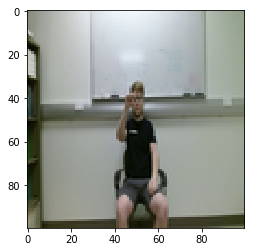

In [53]:
# Display an image
plt.imshow(X[9].astype(np.uint8))

In [54]:
# Print some Y's and J's. J = 0 means left hand, J = 1 means right hand.
# Y = 1 means hand is present in the image.
print(Y[:10])
print(Hand_Info[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


In [55]:
X[4].shape

(100, 100, 3)

In [3]:
labels = gen_labels2(Y, Joints)

In [86]:
np.argwhere(labels[4] == 1)


array([[1, 1, 0]], dtype=int64)

In [92]:
_, cx, cy, h, w = labels[4][1][1]


In [123]:
# convert cx, cy back to consider the full image  #Need grid position! 1 -> x_grid = 1, same for y
cx = (1+cx)/3
cy = (1+cy)/3
print(cx, cy, h , w)

0.5594229166666665 0.4293481481481481 0.05566249999999995 0.12019259259259257


In [122]:
_, cx, cy, h, w = labels[1][1][1]
print(cx, cy, h , w)

0.6782687499999998 0.2880444444444443 0.05566249999999995 0.12019259259259257


In [129]:
#Joints[4]

# PyTorch    (YOLO?)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

In [3]:
dtype = torch.FloatTensor # the CPU datatype

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [98]:
X, Y, Joints, Hand_Info = read_img_data2(10)

In [99]:
Y_train = gen_labels2(Y, Joints, grid_size=3)
Y_rolled = np.rollaxis(Y_train, 3, 1)
print('Y_rolled shape: ', Y_rolled.shape)
X_rolled = to_channels_first2(X)
# Y_rolled = to_channels_first(Y_train)
print('X_rolled shape: ', X_rolled.shape)
# print('Y_rolled shape: ', Y_rolled.shape)

Y_rolled shape:  (10, 5, 3, 3)
X_rolled shape:  (10, 3, 100, 100)


In [100]:
Y_train = torch.from_numpy(Y_rolled)
Y_train = Y_train.type(dtype)
X_train = torch.from_numpy(X_rolled).type(dtype)
print(X_train.size())
print(Y_train.size())

torch.Size([10, 3, 100, 100])
torch.Size([10, 5, 3, 3])


In [70]:
#Y = Y.reshape(Y.shape[0], 1,1,1)

In [71]:
Y_train.shape

torch.Size([5, 5, 3, 3])

In [72]:
# Y = torch.from_numpy(Y)
# Y=Y.type(dtype)
# Y.type

In [73]:
# print(Y_train[:,:])
# plt.imshow(X[10])

In [122]:
def train(X, Y, model, loss_fn, optimizer, batch_size=10, num_epochs=1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
#         model.train()
        # X_batch, Y_batch = ...
        x_var = Variable(X.type(dtype))
        y_var = Variable(Y.type(dtype))

        scores = model(x_var)

        loss = loss_fn(scores, y_var)
#         if (t + 1) % print_every == 0:
#             print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('loss: ', loss)

In [110]:
fixed_model_base = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(64, 64, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(),
        nn.Conv2d(64, 32, kernel_size=3, stride=1),
        #nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(),
        nn.Conv2d(32, 5, kernel_size=2, stride=1),
        nn.ReLU(inplace=True),
        nn.Dropout2d(),
#         nn.Conv2d(16, 7, kernel_size=3, stride=1),
#         nn.ReLU(inplace=True),
        #nn.LogSigmoid(),
        #nn.Linear(1,1)
        nn.Softmax()
    )

fixed_model = fixed_model_base.type(dtype)

# def conditional_loss():
# #     return nn.MSELoss().type(dtype)
#     def loss(Output, Y):
#         N = Y.shape[0]
#         grid_size = Y.shape[2]
#         loss = 0.
#         for out, y in (zip(Output, Y)):
#             for i in range(grid_size):
#                 for j in range(grid_size):
#                     if abs(y[0,i,j] - 1) < 0.01:
#                         # loss = loss + nn.CrossEntropyLoss()((out[0,i,j],2), y[0,i,j])
#                         loss = loss + ((out[:5,i,j] - y[:5,i,j])**2).sum()
#                     else:
#                         loss = loss + (out[0,i,j] - y[0,i,j])**2  # loss computed on only p_c
#         return loss / N
    
#     return loss

#loss_fn = conditional_loss()


In [104]:
import math

In [76]:
math.sqrt(25)

5.0

In [116]:
def yolo_loss(Output, Y_train):
    sum1 = 0
    count = 0
    for out , label in (zip(Output, Y_train)):
        for i in range(3):
            for j in range(3):
                c_hat = iou([Y_train[count][1][i][j] - (Y_train[count][3][i][j])/2, Y_train[count][2][i][j] + (Y_train[count][4][i][j]/2),Y_train[count][1][i][j] + (Y_train[count][3][i][j])/2, Y_train[count][2][i][j] - (Y_train[count][4][i][j]/2)],
                              [Output[count][1][i][j] - (Output[count][3][i][j])/2, Output[count][2][i][j] + (Output[count][4][i][j]/2),Output[count][1][i][j] + (Output[count][3][i][j])/2, Output[count][2][i][j] - (Output[count][4][i][j]/2)] )
                #print(c_hat)
                if Y_train[count][0][i][j] == 1:
                    sum1 += 1 * ((Y_train[count][1][i][j]- Output[count][1][i][j])**2 + (Y_train[count][2][i][j]- Output[count][2][i][j])**2)
                    sum1 += 1 * ((math.sqrt(Y_train[count][3][i][j])- math.sqrt(Output[count][3][i][j]))**2 + (math.sqrt(Y_train[count][4][i][j])- math.sqrt(Output[count][4][i][j]))**2)
                    #sum1 += 5 * ((math.sqrt(Y_train[count][3][i][j])- math.sqrt(Output[count][3][i][j]))**2 + (math.sqrt(Y_train[count][4][i][j])- math.sqrt(Output[count][4][i][j]))**2)
                    sum1 += (Y_train[count][0][i][j] -c_hat)**2
                    sum1 += (Y_train[count][0][i][j] - Output[count][0][i][j])**2
                    
                else:
                    sum1 += 0.5*(Y_train[count][0][i][j] -c_hat)**2
        count +=1
    return sum1

        
    

In [121]:
#loss_fn = yolo_loss().type(dtype)
loss_fn = nn.MSELoss().type(dtype)
#loss_fn = nn.L1Loss().type(dtype)
optimizer = optim.RMSprop(fixed_model.parameters(), lr= 1e-4)
#loss_fn = nn.CrossEntropyLoss().type(dtype)
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

fixed_model.apply(init_weights)
# in your training loop:
it = 50
optimizer.zero_grad()   # zero the gradient buffers
fixed_model.train()
c = 0.0002
#Y_train_ = Y_train.type(torch.LongTensor)
for iter in range(it):
    output = fixed_model(X_train)
    loss = yolo_loss(output, Y_train)
    #loss = loss_fn(output, Y_train)
    optimizer.zero_grad()
    loss.backward()
#     for param_group in optimizer.param_groups:
#         param_group['lr'] -=c
    optimizer.step()    # Does the update
    
    print('loss :' , loss.item())

C:\Users\zarin\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss : 14.828473091125488
loss : 9.779740333557129
loss : 14.149649620056152
loss : 10.276118278503418
loss : 10.470381736755371
loss : 14.917530059814453
loss : 10.984037399291992
loss : 9.889779090881348
loss : 11.17957592010498
loss : 10.277547836303711
loss : 11.782621383666992
loss : 10.38658332824707
loss : 11.390266418457031
loss : 10.731635093688965
loss : 10.998208045959473
loss : 10.95337963104248
loss : 9.735220909118652
loss : 9.889779090881348
loss : 11.602925300598145
loss : 10.197389602661133
loss : 9.889779090881348
loss : 10.1956148147583
loss : 9.889779090881348
loss : 9.895752906799316
loss : 10.899325370788574
loss : 9.506752967834473
loss : 10.561976432800293
loss : 10.533440589904785
loss : 9.889779090881348
loss : 13.676725387573242
loss : 9.889779090881348
loss : 9.889779090881348
loss : 9.889779090881348
loss : 10.495622634887695
loss : 13.640118598937988
loss : 9.889779090881348
loss : 10.94743824005127
loss : 9.889779090881348
loss : 11.227762222290039
loss :

In [118]:
preds = fixed_model(X_train)

C:\Users\zarin\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [114]:
preds

tensor([[[[ 7.8925e-04,  5.1939e-03,  6.0076e-02],
          [ 3.3005e-02,  7.3526e-04,  6.1069e-03],
          [ 4.5494e-04,  1.2319e-01,  2.2813e-03]],

         [[ 7.8925e-04,  5.1939e-03,  6.0076e-02],
          [ 3.3005e-02,  7.3526e-04,  6.1069e-03],
          [ 4.5494e-04,  1.2319e-01,  2.2813e-03]],

         [[ 7.8925e-04,  5.1939e-03,  6.0076e-02],
          [ 3.3005e-02,  7.3526e-04,  6.1069e-03],
          [ 4.5494e-04,  1.2319e-01,  2.2813e-03]],

         [[ 7.8925e-04,  5.1939e-03,  6.0076e-02],
          [ 3.3005e-02,  7.3526e-04,  6.1069e-03],
          [ 4.5494e-04,  1.2319e-01,  2.2813e-03]],

         [[ 9.9684e-01,  9.7922e-01,  7.5970e-01],
          [ 8.6798e-01,  9.9706e-01,  9.7557e-01],
          [ 9.9818e-01,  5.0725e-01,  9.9087e-01]]],


        [[[ 5.1145e-02,  4.0637e-03,  7.8376e-03],
          [ 2.0000e-01,  1.4324e-01,  1.0155e-01],
          [ 2.0000e-01,  3.1682e-03,  2.0000e-01]],

         [[ 5.1145e-02,  4.0637e-03,  7.8376e-03],
          [ 2.000

In [120]:
Y_train

tensor([[[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.6867,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.2806,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0651,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.1222,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.6783,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.2880,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
       

# Need to use this output to calculate confidence and then make everything else zero except the grid with max confidence

In [128]:

#CRAP BELOW


In [118]:
preds.shape
new = preds
new =new.detach().numpy()


In [120]:
new = new.reshape(new.shape[0],)

In [121]:
new

array([0.01135982, 0.87692744, 0.6167153 , 0.5396809 , 0.01177701,
       0.01216818, 0.1118563 , 0.87692744, 0.755402  , 0.87692744,
       0.03742406, 0.87692744, 0.66704714, 0.87692744, 0.7314897 ,
       0.0214721 , 0.87692744, 0.87692744, 0.87692744, 0.5817198 ,
       0.87692744, 0.87692744, 0.43635008, 0.03580783, 0.87692744,
       0.87692744, 0.80255103, 0.87692744, 0.87692744, 0.01138497,
       0.01135982, 0.02130419, 0.0114847 , 0.87692744, 0.87692744,
       0.01241615, 0.87692744, 0.01145151, 0.87692744, 0.01138929,
       0.01158636, 0.01149289, 0.87692744, 0.06400666, 0.02028817,
       0.2257802 , 0.87692744, 0.87692744, 0.87692744, 0.04292852],
      dtype=float32)

In [122]:
Yn = Y.reshape(Y.shape[0],)
Yn

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.])

In [124]:
Yn = Yn.detach().numpy()
Yn.shape


(50,)

In [127]:
Yn.shape[0]

50

In [135]:
count = 0
w = 0
for i in range(Yn.shape[0]):
    if new[i]>0.5:
        if Yn[i] ==1:
            count +=1
        else:
            w+=1
    else:
        if Yn[i] ==1:
            w+=1
        else:
            count+=1
print(count, w)
            

30 20


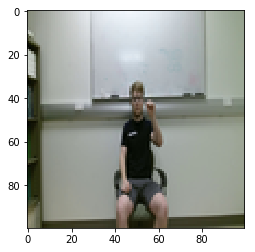

In [359]:
plt.imshow(X[4].astype('uint8'))

In [253]:
l = 0.
l = l + (output[0][:5,1,1] - Y_train[0][:5,1,1]).sum()**2
l

tensor(9.9404)

In [255]:
l = 0.
l = l + (output[0][0,1,1] - Y_train[0][0,1,1])**2
l

tensor(1.)

In [273]:
loss_fn = nn.MSELoss().type(dtype)
print(output[0][:][0][0])
print(Y_train[0][:][0][0])
print(Y_train[0][0])
print(Y_train[0][:5,1,1])
print(output[0][:5,1,1])
loss_fn(output[0][:5,1,1], Y_train[0][:5,1,1])

tensor([ 0.,  0.,  0.])
tensor([ 0.,  0.,  0.])
tensor([[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]])
tensor([ 1.0000,  0.5622,  0.4269,  0.1222,  0.0651])
tensor([ 0.,  0.,  0.,  0.,  0.])


tensor(0.3035)

In [242]:
(output[0][:5,1,1] - Y_train[0][:5,1,1])

tensor([-1.0000, -0.5622, -0.4269, -0.1222, -0.0651])

In [274]:
((output[0][:5,1,1] - Y_train[0][:5,1,1])**2).sum()

tensor(1.5175)

In [127]:
#train(X_train, Y, fixed_model, loss_fn, optimizer, num_epochs=10)

In [126]:
#train(fixed_model, loss_fn, optimizer)